In [1]:
print('kernel running (use gpu3)')

kernel running (use gpu3)


In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from keras.utils import np_utils
import tensorflow.keras as keras
import random


Using TensorFlow backend.


In [3]:
from azureml.core import Experiment, Run, Workspace
import azureml.core

# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

ws = Workspace.from_config()


SDK version: 1.20.0


# Load the Buffy scripts

In [4]:
#Just the first 20 shows for speed
allscripts = os.listdir("./BuffyScripts")
raw_text_all = ""
i=-1
for script in allscripts:
    i = i+1
    # load ascii text and covert to lowercase
    if (i < 20):
        filename = script
        raw_text = open("BuffyScripts/" + filename, 'r', encoding='utf-8').read()
        raw_text = raw_text.lower()
        raw_text_all = raw_text_all + raw_text

text = raw_text_all

print('text length', len(text))
chars = sorted(list(set(text))) # getting all unique chars
print('total chars: ', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))



text length 885808
total chars:  58


In [5]:
#Identify all the characters we have in the files
chars

['\n',
 ' ',
 '!',
 '"',
 '#',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 '?',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '~',
 '©',
 '»',
 '¼',
 'ã']

In [6]:
#split our data up into sections with a length of 40 character
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
#

In [7]:
#Display of sections
print("length: " + str(len(sentences[360])))
print(sentences[360])
print("   " + sentences[361])
print("   " + "   " + sentences[362])
print("   " + "   " + "   " + sentences[363])

s = 1847
print(sentences[s])
print("   " + sentences[s+1])
print("   " + "   " + sentences[s+2])
print("   " + "   " + "   " + sentences[s+3])

length: 40
he gym it's so cool. you can see the who
   gym it's so cool. you can see the whole 
       it's so cool. you can see the whole tow
         's so cool. you can see the whole town. 

mr. flutie: buffy, don't worry. any oth
   . flutie: buffy, don't worry. any other 
      lutie: buffy, don't worry. any other sch
         ie: buffy, don't worry. any other school


In [8]:
#model = Sequential()
#model.add(LSTM(256, input_shape=(maxlen, len(chars)), return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(256))
#model.add(Dropout(0.2))
#model.add(Dense(y.shape[1], activation='softmax'))
#model.compile(loss='categorical_crossentropy', optimizer='adam')

## Standard DNN - good for classification - but context is lossed every time the input changes

![image.png](attachment:image.png)

![image.png](attachment:image.png)

![image.png](attachment:image.png)

![image.png](attachment:image.png)

The DNN has no context on if the last character should be a y or T

# ------------------------------- B u f f T -------------------------------

# Recurrent DNN - output is fed through to next input

![image.png](attachment:image.png)

## BPTT (backpropagation through time)

![image.png](attachment:image.png)

#  ------------------------------- B u f f y -------------------------------

# RDNN can suffer from the vanishing gradient problem

![image.png](attachment:image.png)

# LSTM Long Short Term Memory

![image.png](attachment:image.png)

Input gate<br>
Forget Gate<br>
Output gate<br>

![image-2.png](attachment:image-2.png)

In [9]:
#Create a simple LSTM DNN 
model = Sequential()
#model.add(LSTM(128, input_shape=(maxlen, len(chars)), return_sequences=True))
model.add(LSTM(64, input_shape=(maxlen, len(chars)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
#model.add(LSTM(128))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
#model.compile(loss='categorical_crossentropy', optimizer='adam')


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 64)            31488     
_________________________________________________________________
dropout (Dropout)            (None, 40, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 58)                3770      
_________________________________________________________________
activation (Activation)      (None, 58)                0         
Total params: 68,282
Trainable params: 68,282
Non-trainable params: 0
_________________________________________________________________


In [12]:
#pip install pydot
#! pip install graphviz 

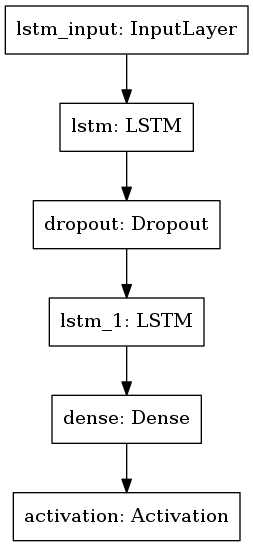

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',  show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True)

In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1436937308381062860
]


Epoch 1/515
288/288 [==============================] - 10s 34ms/step - loss: 2.3006
Epoch 2/515
288/288 [==============================] - 10s 33ms/step - loss: 1.7085
Epoch 3/515
288/288 [==============================] - 10s 33ms/step - loss: 1.5711
Epoch 4/515
288/288 [==============================] - 10s 33ms/step - loss: 1.5026
Epoch 5/515
288/288 [==============================] - 10s 33ms/step - loss: 1.4586
Epoch 6/515
288/288 [==============================] - 10s 33ms/step - loss: 1.4288
Epoch 7/515
288/288 [==============================] - 10s 33ms/step - loss: 1.4044
Epoch 8/515
288/288 [==============================] - 10s 33ms/step - loss: 1.3873
Epoch 9/515
288/288 [==============================] - 10s 33ms/step - loss: 1.3747
Epoch 10/515
288/288 [==============================] - 10s 33ms/step - loss: 1.3616
Epoch 11/515
288/288 [==============================] - 10s 33ms/step - loss: 1.3515
Epoch 12/515
288/288 [==============================] - 10s 33ms/step - lo

288/288 [==============================] - 10s 34ms/step - loss: 1.2036
Epoch 193/515
288/288 [==============================] - 10s 34ms/step - loss: 1.2034
Epoch 194/515
288/288 [==============================] - 10s 34ms/step - loss: 1.2022
Epoch 195/515
288/288 [==============================] - 10s 34ms/step - loss: 1.2036
Epoch 196/515
288/288 [==============================] - 10s 34ms/step - loss: 1.2031
Epoch 197/515
288/288 [==============================] - 10s 34ms/step - loss: 1.2030
Epoch 198/515
288/288 [==============================] - 10s 34ms/step - loss: 1.2035
Epoch 199/515
288/288 [==============================] - 10s 34ms/step - loss: 1.2029
Epoch 200/515
288/288 [==============================] - 10s 34ms/step - loss: 1.2033
Epoch 201/515
288/288 [==============================] - 10s 34ms/step - loss: 1.2037 0s - lo
Epoch 202/515
288/288 [==============================] - 10s 34ms/step - loss: 1.2041
Epoch 203/515
288/288 [==============================] - 10s

288/288 [==============================] - 10s 34ms/step - loss: 1.1839
Epoch 383/515
288/288 [==============================] - 10s 34ms/step - loss: 1.1850
Epoch 384/515
288/288 [==============================] - 10s 34ms/step - loss: 1.1852
Epoch 385/515
288/288 [==============================] - 10s 34ms/step - loss: 1.1829
Epoch 386/515
288/288 [==============================] - 10s 34ms/step - loss: 1.1821
Epoch 387/515
288/288 [==============================] - 10s 34ms/step - loss: 1.1838
Epoch 388/515
288/288 [==============================] - 10s 34ms/step - loss: 1.1831
Epoch 389/515
288/288 [==============================] - 10s 34ms/step - loss: 1.1842
Epoch 390/515
288/288 [==============================] - 10s 34ms/step - loss: 1.1844
Epoch 391/515
288/288 [==============================] - 10s 34ms/step - loss: 1.1829
Epoch 392/515
288/288 [==============================] - 10s 34ms/step - loss: 1.1837
Epoch 393/515
288/288 [==============================] - 10s 34ms/st

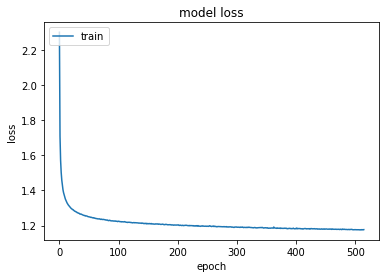

In [38]:
# choose a name for experiment
epochs = 515

experiment=Experiment(ws, 'buffy')

run = experiment.start_logging(snapshot_directory=None)

history = model.fit(x, y, batch_size=1028, epochs=epochs)

model.save('predmodel.h5')
run.upload_file("outputs/predmodel.h5", "predmodel.h5")
#run.register_model(model_name='model' + str(epochs), model_path='outputs/predmodel')

run.log('epochs', epochs)
run.log('LSTM', 64)
run.log('Min Loss', min(min(history.history.values())))

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
run.log_image("loss", path=None, plot=plt)
plt.show()

run.complete()


In [15]:
experiment=Experiment(ws, 'buffy')

#Return all runs
from tqdm import tqdm
runs = {}
run_metrics = {}
runsorder = {}
i = 0

for r in tqdm(experiment.get_runs()):
    metrics = r.get_metrics()
    if 'epochs' in metrics.keys():
        i = i + 1
        runs[r.id] = r
        run_metrics[r.id] = metrics

6it [00:05,  1.04it/s]


In [16]:
import pandas as pd
pd.DataFrame(run_metrics.values())

,epochs,LSTM,Min Loss,loss
0,515,64,1.175454,aml://artifactId/ExperimentRun/dcid.861e544e-1...
1,500,64,0.983079,aml://artifactId/ExperimentRun/dcid.3333d8e5-4...
2,200,64,1.038818,aml://artifactId/ExperimentRun/dcid.28b29c80-3...
3,100,64,1.115816,aml://artifactId/ExperimentRun/dcid.256cde82-6...
4,20,64,1.381550,aml://artifactId/ExperimentRun/dcid.fa458fdd-5...
5,10,64,1.537578,aml://artifactId/ExperimentRun/dcid.871aa7ff-3...


In [17]:
allruns = pd.DataFrame.from_dict(run_metrics, orient ='index')
allruns

,epochs,LSTM,Min Loss,loss
861e544e-186a-484d-8a7e-2456372857d0,515,64,1.175454,aml://artifactId/ExperimentRun/dcid.861e544e-1...
3333d8e5-441b-40f2-9134-43e92ee36ea0,500,64,0.983079,aml://artifactId/ExperimentRun/dcid.3333d8e5-4...
28b29c80-359b-4c70-9591-b7e8ae25e2f4,200,64,1.038818,aml://artifactId/ExperimentRun/dcid.28b29c80-3...
256cde82-649e-4e75-bb63-6d91e3cb3dc0,100,64,1.115816,aml://artifactId/ExperimentRun/dcid.256cde82-6...
fa458fdd-56a5-4f5c-9914-949df8536ee8,20,64,1.381550,aml://artifactId/ExperimentRun/dcid.fa458fdd-5...
871aa7ff-3aa4-4dfd-a1e7-f1527c4d07a7,10,64,1.537578,aml://artifactId/ExperimentRun/dcid.871aa7ff-3...


In [18]:
#Get the run
epoch = 515

run_by_epoch = runs[allruns[allruns['epochs'] == epoch].index[0]]

#Get the model
for f in range(len(run_by_epoch.get_file_names())):
    if (run_by_epoch.get_file_names()[f] == 'outputs/predmodel.h5'):
        model_path = run_by_epoch.get_file_names()[f]
model_path

#Download model
res = run_by_epoch.download_file(model_path)
#Load model
model = keras.models.load_model('predmodel.h5')


In [20]:
length = 800 # Amount of text to create
diversity = 0.2

generated = ''

start_index = random.randint(0, len(text) - maxlen - 1)
sentence = text[start_index: start_index + maxlen]

sentence = "buffy: lets go kill some vampires faith "

print(sentence)

for i in range(length):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, preds, 1)
        
        next_index = np.argmax(probas)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char


print(generated)

buffy: lets go kill some vampires faith 


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


that is a stake and then she starts to be the stacks. 
xander: well, i don't know and start to the books. 
buffy: well, i don't know and start that i don't know it work. 
buffy: well, i don't know what you know what you know he does a little good. 
buffy: (to buffy) i don't know her was the master. 
buffy: what's the master? 
buffy: i don't know and goes and there's a student of the stake and starts to be the bronze. 
buffy: i don't know what you should go on the master? 
buffy: what's the hall to the master? 
buffy: (grabs his hand) that's a stake. 
xander: what's the hall? 
buffy: okay, there's a student. 
buffy: i don't know what you know what you don't know what i don't know what you know it was a stake. 
xander: that's the hall of the way. 
buffy: well, i don't know what you know it's


In [ ]:
#import matplotlib.pyplot as plt

#plt.plot(history.history['loss'])
#plt.title('model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
#plt.show()


In [ ]:
def sample(preds, diversity=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / diversity
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
#Save the model to disk
model.save('model200')

In [ ]:
#Load the model
model = keras.models.load_model('model200')

In [ ]:
def generate_text(length, diversity):
    # Get random starting text
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

In [ ]:
print(generate_text(500, 0.1))